In [1]:
!nvidia-smi

Thu Feb 23 19:55:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%cd '/content/drive/MyDrive/Image Classification'

/content/drive/MyDrive/Image Classification


In [2]:
!ls

caltech_10_large      __MACOSX	     rsNet_last.pt
caltech_10_large.zip  rsNet_best.pt  Untitled0.ipynb


In [4]:
# !unzip caltech_10_large.zip

Streaming output truncated to the last 5000 lines.
  inflating: caltech_10_large/train/234.tweezer/234_0108.jpg  
  inflating: __MACOSX/caltech_10_large/train/234.tweezer/._234_0108.jpg  
  inflating: caltech_10_large/train/234.tweezer/234_0109.jpg  
  inflating: __MACOSX/caltech_10_large/train/234.tweezer/._234_0109.jpg  
  inflating: caltech_10_large/train/234.tweezer/234_0121.jpg  
  inflating: __MACOSX/caltech_10_large/train/234.tweezer/._234_0121.jpg  
  inflating: caltech_10_large/train/234.tweezer/234_0069.jpg  
  inflating: __MACOSX/caltech_10_large/train/234.tweezer/._234_0069.jpg  
  inflating: caltech_10_large/train/234.tweezer/234_0041.jpg  
  inflating: __MACOSX/caltech_10_large/train/234.tweezer/._234_0041.jpg  
  inflating: caltech_10_large/train/234.tweezer/234_0055.jpg  
  inflating: __MACOSX/caltech_10_large/train/234.tweezer/._234_0055.jpg  
  inflating: caltech_10_large/train/234.tweezer/234_0082.jpg  
  inflating: __MACOSX/caltech_10_large/train/234.tweezer/._234_0

In [3]:
# import time
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import torch
# import torchvision
# from torchvision import datasets, transforms, models
# from torchvision.utils import make_grid
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.nn as nn
# from torch import optim

#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [4]:
train_transforms =  transforms.Compose([
                    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                    transforms.RandomRotation(degrees=15),
                    transforms.RandomHorizontalFlip(),
                    transforms.CenterCrop(size=224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])])
test_valid_transforms =  transforms.Compose([
                          transforms.Resize(size=256),
                          transforms.CenterCrop(size=224),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406],
                                                [0.229, 0.224, 0.225])])

In [5]:
dataset = 'caltech_10_large'
bs = 32


train_dataset = datasets.ImageFolder('./'+dataset+'/train/', transform=train_transforms)
valid_dataset = datasets.ImageFolder('./'+dataset+'/valid/', transform=test_valid_transforms)
test_dataset = datasets.ImageFolder('./'+dataset+'/test/', transform=test_valid_transforms)

train_data_size = len(train_dataset)
valid_data_size = len(valid_dataset)
test_data_size = len(test_dataset)




train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True)


classes = {v: k for k, v in train_dataset.class_to_idx.items()}

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def imshow(image, normalize=True):
    """Imshow for Tensor."""
    # Defining plot
    fig, ax = plt.subplots()
    # convert to numpy
    image = image.numpy().transpose((1, 2, 0))
    # Normalize
    if normalize:
      mean = np.array([0.5, 0.5, 0.5])
      std = np.array([0.5, 0.5, 0.5])
      image = std * image + mean
      image = np.clip(image, 0, 1)
    # Displaying Image
    ax.imshow(image)
    ax.spines['top'].set_visible(False) #to make the borders false that is not visible
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0) #to remove the axis line from the image 
    ax.set_xticklabels('') #to remove the axis from the image
    ax.set_yticklabels('')
    
    return ax

In [13]:
images, labels = next(iter(train_dataloader))

212.teapot


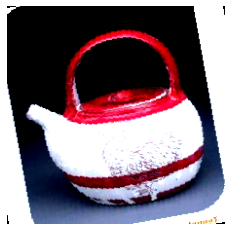

In [14]:
imshow(images[0]);
print(classes[int(labels[0].numpy())])

212.teapot 074.flashlight 115.ice-cream-cone 056.dog 097.harmonica 139.megaphone 213.teddy-bear


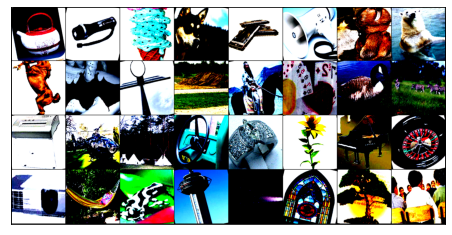

In [15]:
def show_batch():
    """Plot images grid of single batch"""
    fig,ax = plt.subplots(figsize = (8,4))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
show_batch()
print(' '.join('%s' % classes[labels[j].item()] for j in range(7)))

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, len(classes))

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        # Flatten the tensor
        x = x.view(-1, 128 * 28 * 28)

        # Pass input through fully connected layers
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x


In [23]:
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=257, bias=True)
)


In [18]:
loss_func = nn.CrossEntropyLoss() 
loss_func_rs = nn.NLLLoss()

In [9]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [11]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(classes)), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

In [24]:
optimizer = optim.Adam(cnn.parameters())
optimizer_rs = optim.Adam(resnet50.parameters())

In [36]:
# from torch.utils.data import DataLoader
# # Applying Transforms to the Data
# image_transforms = { 
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#         transforms.RandomRotation(degrees=15),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ]),
#     'valid': transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ])
# }

In [13]:
# # Load the Data

# # Set train and valid directory paths

# dataset = 'caltech_10_large'

# train_directory = os.path.join(dataset, 'train')
# valid_directory = os.path.join(dataset, 'valid')
# test_directory = os.path.join(dataset, 'test')

# # Batch size
# bs = 32

# # Number of classes
# num_classes = len(os.listdir(valid_directory))  #10#2#257
# print(num_classes)

# # Load Data from folders
# data = {
#     'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
#     'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
#     'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
# }

# # Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

# # Size of Data, to be used for calculating Average Loss and Accuracy
# train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
# test_data_size = len(data['test'])

# # Create iterators for the Data loaded using DataLoader module
# train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
# test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

In [14]:
from tqdm import tqdm
def train_valid_test(model, loss_criterion, optimizer, epochs, train_dataloader, test_dataloader, valid_dataloader, model_name):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None
    print('-------------------------------- Training --------------------------------')
    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(valid_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            torch.save(model, model_name+'_best.pt')
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        torch.save(model, model_name+'_last.pt')
    print('-------------------------------- Testing --------------------------------')
    correct = 0
    total = 0
    with torch.no_grad():
        # for data in test_dataloader:
        for i, data in enumerate(tqdm(test_dataloader, 0)):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet50(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'\nAccuracy of the {model_name} on the {test_data_size} test images: {100 * correct / total}')
    return model, history, best_epoch
    

In [17]:
trained_model, history, best_epoch = train_valid_test(resnet50, loss_func_rs, optimizer_rs, 30, train_dataloader, test_dataloader, valid_dataloader, "rsNet")

-------------------------------- Training --------------------------------


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30
Epoch : 000, Training: Loss - 0.0000, Accuracy - 28.8893%, 
		Validation : Loss - 1.5052, Accuracy - 65.6667%, Time: 281.1996s


  3%|▎         | 1/30 [04:41<2:16:05, 281.56s/it]

Epoch: 2/30
Epoch : 001, Training: Loss - 0.0000, Accuracy - 51.1270%, 
		Validation : Loss - 1.1140, Accuracy - 71.6000%, Time: 279.7209s


  7%|▋         | 2/30 [09:22<2:11:06, 280.94s/it]

Epoch: 3/30
Epoch : 002, Training: Loss - 0.0000, Accuracy - 56.3169%, 
		Validation : Loss - 1.0428, Accuracy - 73.9333%, Time: 281.1352s


 10%|█         | 3/30 [14:03<2:06:34, 281.28s/it]

Epoch: 4/30
Epoch : 003, Training: Loss - 0.0000, Accuracy - 59.2323%, 
		Validation : Loss - 0.9582, Accuracy - 74.0333%, Time: 281.3725s


 13%|█▎        | 4/30 [18:45<2:01:57, 281.46s/it]

Epoch: 5/30
Epoch : 004, Training: Loss - 0.0000, Accuracy - 60.4369%, 
		Validation : Loss - 0.9390, Accuracy - 75.3667%, Time: 277.4496s


 17%|█▋        | 5/30 [23:23<1:56:43, 280.15s/it]

Epoch: 6/30
Epoch : 005, Training: Loss - 0.0000, Accuracy - 61.0821%, 
		Validation : Loss - 0.9260, Accuracy - 75.8667%, Time: 274.6112s


 20%|██        | 6/30 [27:58<1:51:22, 278.42s/it]

Epoch: 7/30
Epoch : 006, Training: Loss - 0.0000, Accuracy - 61.6660%, 
		Validation : Loss - 0.9201, Accuracy - 75.7333%, Time: 274.4226s


 23%|██▎       | 7/30 [32:33<1:46:17, 277.27s/it]

Epoch: 8/30
Epoch : 007, Training: Loss - 0.0000, Accuracy - 62.4500%, 
		Validation : Loss - 0.8967, Accuracy - 76.3333%, Time: 274.4321s


 27%|██▋       | 8/30 [37:08<1:41:22, 276.50s/it]

Epoch: 9/30
Epoch : 008, Training: Loss - 0.0000, Accuracy - 62.7113%, 
		Validation : Loss - 0.8900, Accuracy - 76.9667%, Time: 272.3259s


 30%|███       | 9/30 [41:40<1:36:21, 275.31s/it]

Epoch: 10/30
Epoch : 009, Training: Loss - 0.0000, Accuracy - 63.3646%, 
		Validation : Loss - 0.9087, Accuracy - 76.7000%, Time: 268.7565s


 33%|███▎      | 10/30 [46:09<1:31:07, 273.40s/it]

Epoch: 11/30
Epoch : 010, Training: Loss - 0.0000, Accuracy - 63.2626%, 
		Validation : Loss - 0.8928, Accuracy - 76.6333%, Time: 272.9855s


 37%|███▋      | 11/30 [50:43<1:26:33, 273.37s/it]

Epoch: 12/30
Epoch : 011, Training: Loss - 0.0000, Accuracy - 63.8506%, 
		Validation : Loss - 0.8890, Accuracy - 77.3667%, Time: 282.0881s


 40%|████      | 12/30 [55:25<1:22:50, 276.13s/it]

Epoch: 13/30
Epoch : 012, Training: Loss - 0.0000, Accuracy - 64.3242%, 
		Validation : Loss - 0.9059, Accuracy - 77.4333%, Time: 268.8529s


 43%|████▎     | 13/30 [59:54<1:17:38, 274.03s/it]

Epoch: 14/30
Epoch : 013, Training: Loss - 0.0000, Accuracy - 64.4140%, 
		Validation : Loss - 0.8929, Accuracy - 77.4000%, Time: 269.0693s


 47%|████▋     | 14/30 [1:04:24<1:12:42, 272.63s/it]

Epoch: 15/30
Epoch : 014, Training: Loss - 0.0000, Accuracy - 63.9771%, 
		Validation : Loss - 0.9015, Accuracy - 76.6000%, Time: 268.6893s


 50%|█████     | 15/30 [1:08:53<1:07:53, 271.54s/it]

Epoch: 16/30
Epoch : 015, Training: Loss - 0.0000, Accuracy - 64.7611%, 
		Validation : Loss - 0.8948, Accuracy - 77.6333%, Time: 267.6040s


 53%|█████▎    | 16/30 [1:13:21<1:03:06, 270.45s/it]

Epoch: 17/30
Epoch : 016, Training: Loss - 0.0000, Accuracy - 64.9571%, 
		Validation : Loss - 0.8864, Accuracy - 77.7000%, Time: 269.7844s


 57%|█████▋    | 17/30 [1:17:51<58:34, 270.36s/it]  

Epoch: 18/30
Epoch : 017, Training: Loss - 0.0000, Accuracy - 65.4675%, 
		Validation : Loss - 0.8891, Accuracy - 77.3333%, Time: 267.9627s


 60%|██████    | 18/30 [1:22:19<53:57, 269.75s/it]

Epoch: 19/30
Epoch : 018, Training: Loss - 0.0000, Accuracy - 65.2593%, 
		Validation : Loss - 0.8854, Accuracy - 77.3000%, Time: 267.2831s


 63%|██████▎   | 19/30 [1:26:47<49:20, 269.15s/it]

Epoch: 20/30
Epoch : 019, Training: Loss - 0.0000, Accuracy - 65.0960%, 
		Validation : Loss - 0.8834, Accuracy - 77.4667%, Time: 268.0426s


 67%|██████▋   | 20/30 [1:31:15<44:49, 268.95s/it]

Epoch: 21/30
Epoch : 020, Training: Loss - 0.0000, Accuracy - 65.2838%, 
		Validation : Loss - 0.8936, Accuracy - 78.1667%, Time: 267.4020s


 70%|███████   | 21/30 [1:35:43<40:17, 268.59s/it]

Epoch: 22/30
Epoch : 021, Training: Loss - 0.0000, Accuracy - 65.5410%, 
		Validation : Loss - 0.8586, Accuracy - 78.2000%, Time: 271.5488s


 73%|███████▎  | 22/30 [1:40:15<35:56, 269.62s/it]

Epoch: 23/30
Epoch : 022, Training: Loss - 0.0000, Accuracy - 65.3491%, 
		Validation : Loss - 0.8629, Accuracy - 77.4667%, Time: 270.0704s


 77%|███████▋  | 23/30 [1:44:46<31:29, 269.88s/it]

Epoch: 24/30
Epoch : 023, Training: Loss - 0.0000, Accuracy - 65.6554%, 
		Validation : Loss - 0.8692, Accuracy - 78.2333%, Time: 266.9617s


 80%|████████  | 24/30 [1:49:13<26:54, 269.10s/it]

Epoch: 25/30
Epoch : 024, Training: Loss - 0.0000, Accuracy - 65.5533%, 
		Validation : Loss - 0.8838, Accuracy - 78.0000%, Time: 266.7974s


 83%|████████▎ | 25/30 [1:53:40<22:22, 268.51s/it]

Epoch: 26/30
Epoch : 025, Training: Loss - 0.0000, Accuracy - 66.0964%, 
		Validation : Loss - 0.8689, Accuracy - 78.9333%, Time: 267.1856s


 87%|████████▋ | 26/30 [1:58:08<17:52, 268.21s/it]

Epoch: 27/30
Epoch : 026, Training: Loss - 0.0000, Accuracy - 66.6721%, 
		Validation : Loss - 0.8698, Accuracy - 78.9333%, Time: 266.7286s


 90%|█████████ | 27/30 [2:02:35<13:23, 267.86s/it]

Epoch: 28/30
Epoch : 027, Training: Loss - 0.0000, Accuracy - 66.3536%, 
		Validation : Loss - 0.8689, Accuracy - 78.2000%, Time: 266.4602s


 93%|█████████▎| 28/30 [2:07:02<08:55, 267.56s/it]

Epoch: 29/30
Epoch : 028, Training: Loss - 0.0000, Accuracy - 65.8555%, 
		Validation : Loss - 0.8628, Accuracy - 78.6333%, Time: 267.6478s


 97%|█████████▋| 29/30 [2:11:30<04:27, 267.68s/it]

Epoch: 30/30
Epoch : 029, Training: Loss - 0.0000, Accuracy - 66.2638%, 
		Validation : Loss - 0.9025, Accuracy - 77.5667%, Time: 267.7831s


100%|██████████| 30/30 [2:15:58<00:00, 271.94s/it]


-------------------------------- Testing --------------------------------


100%|██████████| 96/96 [00:32<00:00,  2.94it/s]


Accuracy of the ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
trained_model, history, best_epoch = train_valid_test(cnn, loss_func, optimizer, 30, train_dataloader, test_dataloader, valid_dataloader, 'CNN')

-------------------------------- Training --------------------------------


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30
Epoch : 000, Training: Loss - 0.0000, Accuracy - 9.5141%, 
		Validation : Loss - 4.4242, Accuracy - 14.8333%, Time: 263.7457s


  3%|▎         | 1/30 [04:24<2:07:51, 264.54s/it]

Epoch: 2/30
Epoch : 001, Training: Loss - 0.0000, Accuracy - 19.0078%, 
		Validation : Loss - 4.0096, Accuracy - 20.0667%, Time: 263.7235s


  7%|▋         | 2/30 [08:49<2:03:34, 264.79s/it]

Epoch: 3/30
Epoch : 002, Training: Loss - 0.0000, Accuracy - 25.2960%, 
		Validation : Loss - 3.8114, Accuracy - 23.7333%, Time: 260.5043s


 10%|█         | 3/30 [13:11<1:58:30, 263.35s/it]

Epoch: 4/30
Epoch : 003, Training: Loss - 0.0000, Accuracy - 30.3675%, 
		Validation : Loss - 3.6764, Accuracy - 25.6000%, Time: 260.5015s


 13%|█▎        | 4/30 [17:32<1:53:47, 262.58s/it]

Epoch: 5/30
Epoch : 004, Training: Loss - 0.0000, Accuracy - 33.6995%, 
		Validation : Loss - 3.5556, Accuracy - 27.5000%, Time: 259.7437s


 17%|█▋        | 5/30 [21:53<1:49:09, 261.96s/it]

Epoch: 6/30
Epoch : 005, Training: Loss - 0.0000, Accuracy - 37.2928%, 
		Validation : Loss - 3.5621, Accuracy - 27.7333%, Time: 259.3839s


 20%|██        | 6/30 [26:13<1:44:35, 261.48s/it]

Epoch: 7/30
Epoch : 006, Training: Loss - 0.0000, Accuracy - 40.3838%, 
		Validation : Loss - 3.6100, Accuracy - 29.2000%, Time: 258.0559s


 23%|██▎       | 7/30 [30:32<1:39:54, 260.61s/it]

Epoch: 8/30
Epoch : 007, Training: Loss - 0.0000, Accuracy - 43.2013%, 
		Validation : Loss - 3.6223, Accuracy - 29.7667%, Time: 259.2050s


 27%|██▋       | 8/30 [34:52<1:35:29, 260.42s/it]

Epoch: 9/30
